### Modeling Notebook

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures , LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

### Model Validation:
from sklearn.metrics import accuracy_score, precision_score, recall_score,balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay, log_loss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.ensemble import RandomForestClassifier

import pickle
import joblib

### Suppress Warnings:
import warnings
warnings.filterwarnings('ignore')



In [2]:
featurs=features =pd.read_csv('../Data/clean_data.csv' , index_col=0)

In [3]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50142 entries, 0 to 59399
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             16558 non-null  float64
 1   funder                 50142 non-null  object 
 2   gps_height             34219 non-null  float64
 3   longitude              50142 non-null  float64
 4   latitude               50142 non-null  float64
 5   num_private            718 non-null    float64
 6   basin                  50142 non-null  object 
 7   region_code            50142 non-null  int64  
 8   district_code          50142 non-null  int64  
 9   lga                    50142 non-null  object 
 10  population             33264 non-null  float64
 11  public_meeting         50142 non-null  bool   
 12  permit                 50142 non-null  bool   
 13  extraction_type        50142 non-null  object 
 14  extraction_type_class  50142 non-null  object 
 15  ma

our target column is status_group

    0 Funcional
    1 Functional , needs repair
    2 non functional


In [4]:
features.status_group.value_counts(normalize=True)

functional                 0.547146
non functional             0.386622
functional needs repair    0.066232
Name: status_group, dtype: float64

In [5]:
#casting the data type of region and district code to object , they needed to be catagorical
features['region_code'] = features['region_code'].astype('O')
features['district_code'] = features['district_code'].astype('O')

In [6]:
#numerical and catagorical columns
cat_columns=list(features.select_dtypes(include='O').columns)
num_columns=list(features.select_dtypes(exclude='O').columns)

In [7]:
cat_columns.remove('status_group')

In [8]:
# create features and target
X = features.drop('status_group', axis=1)
y = features.status_group

encoder = LabelEncoder()
y_transorm = encoder.fit_transform(y)

#y_transorm=pd.get_dummies(y , drop_first=True)


# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_transorm, test_size=0.2, random_state=42)

In [9]:
y_transorm

array([0, 0, 2, ..., 0, 0, 0])

#### Column transform

In [10]:
num_pipeline = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='median' ,add_indicator=True)),
    ('ss', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute_cat', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore',sparse=True))
])

In [11]:
col_trans=ColumnTransformer(transformers=[
    ('nums', num_pipeline, num_columns),
    ('cats', cat_pipeline, cat_columns)
], remainder='passthrough', n_jobs=-1)

In [12]:
y_train

array([0, 1, 2, ..., 2, 0, 2])

### Logistic regression

In [124]:
# first simple model
logreg_pipe = Pipeline([
    ('colt', col_trans),
    ('logreg', LogisticRegression(C=0.1 ,n_jobs=-1))
])

logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [125]:
logreg_pipe.score(X_train , y_train)

0.7693266522075137

### use class wieght

In [ ]:
'logreg__C': 1,
 'logreg__max_iter': 1000,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.001

In [156]:
logreg_pipe2 = Pipeline([
    ('colt', col_trans),
    ('logreg', LogisticRegression(class_weight='balanced' ,C=1 ,n_jobs=-1 , solver='liblinear',max_iter=1000, tol=0.001))
])

logreg_pipe2.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [158]:
logreg_pipe2.score(X_train , y_train) , logreg_pipe2.score(X_test , y_test)

(0.7490838381572059, 0.7397547113371223)

In [160]:
y_test_predd=logreg_pipe2.predict(X_test)
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

           0       0.84      0.72      0.77      5523
           1       0.27      0.73      0.40       686
           2       0.81      0.73      0.77      3820

    accuracy                           0.72     10029
   macro avg       0.64      0.73      0.65     10029
weighted avg       0.79      0.72      0.75     10029



In [217]:
Log_cv_scores = cross_val_score(logreg_pipe2, X_train, y_train, cv=5, scoring='recall_macro', n_jobs=-1)

In [218]:
Log_cv_scores

array([0.65757636, 0.64357713, 0.64092842, 0.6489319 , 0.64805132])

In [144]:
params = {
    'logreg__solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'logreg__max_iter': [1000],
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__tol': [0.001]
}

binary_search_2 = GridSearchCV(logreg_pipe2, params, n_jobs=6, verbose=2)

In [145]:
binary_search_2.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   42.5s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  9.2min finished


GridSearchCV(estimator=Pipeline(steps=[('colt',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('nums',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                       

In [146]:
def get_df(grid_search, model_name):
    results = grid_search.cv_results_
    df = pd.DataFrame({
        'Model': model_name,
        'Params': results['params'],
        'Mean_Test_Score': results['mean_test_score'],
        'Rank': results['rank_test_score']
    })
    return df

In [154]:
binary_df_2 = get_df(grid_search=binary_search_2, model_name='binary_2')
binary_df_2.sort_values('Mean_Test_Score', ascending=False).head(1)['Params'].values[0]

{'logreg__C': 1,
 'logreg__max_iter': 1000,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.001}

### Random Forest Classification

In [79]:
logreg_pipe3 = Pipeline([
    ('colt', col_trans),
    ('logreg', RandomForestClassifier(class_weight='balanced',min_samples_split=6,min_samples_leaf=4,n_estimators=100, random_state=42))
])

logreg_pipe3.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [80]:
logreg_pipe3.score(X_train , y_train) , logreg_pipe3.score(X_test , y_test)

(0.7472889088325481, 0.7239006880047861)

In [81]:
y_test_pred=logreg_pipe3.predict(X_test)

In [82]:
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

           0       0.84      0.72      0.77      5523
           1       0.27      0.73      0.40       686
           2       0.81      0.73      0.77      3820

    accuracy                           0.72     10029
   macro avg       0.64      0.73      0.65     10029
weighted avg       0.79      0.72      0.75     10029



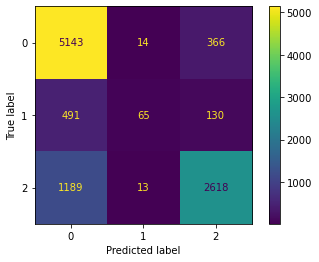

In [58]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [215]:
radf_cv_scores = cross_val_score(logreg_pipe3, X_train, y_train, cv=5, scoring='recall_macro', n_jobs=-1)

In [216]:
radf_cv_scores

array([0.70981139, 0.70340706, 0.70312695, 0.71816938, 0.70284165])

### Feature importance

In [14]:
colt = logreg_pipe3.named_steps['colt']
num_trans = colt.transformers_[0][2]
cat_trans = colt.transformers_[1][2]

In [15]:
num_trans

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'population',
 'public_meeting',
 'permit',
 'age_waterpoint']

In [16]:
feature_names = num_trans +cat_trans

In [17]:
rf_classifier = logreg_pipe3.named_steps['logreg']
feature_importances = rf_classifier.feature_importances_

In [18]:
(feature_importances*100).sum()

99.99999999999999

In [19]:
print("Feature Importances:")
for feature, importance in zip(feature_names, feature_importances):
    print(f"{feature}: {importance}")

Feature Importances:
amount_tsh: 0.019082179859853828
gps_height: 0.03519022011156468
longitude: 0.05461311335868211
latitude: 0.05191194561020363
num_private: 0.0009617657361641954
population: 0.025761046148539204
public_meeting: 0.005220390725268393
permit: 0.005891112998828176
age_waterpoint: 0.042076744853891575
funder: 0.01885412696188452
basin: 0.0044540753934044115
region_code: 0.0006056078956077324
district_code: 0.00419643285714848
lga: 1.913698568836463e-05
extraction_type: 5.327333031976855e-05
extraction_type_class: 0.0
management: 5.289539739442291e-05
payment_type: 0.0
water_quality: 7.0370460647903715e-06
quantity: 0.0
source: 2.8323571554346277e-05
source_class: 4.147842297812547e-06
waterpoint_type: 3.510669311611832e-07


In [ ]:
# cross_val_scores = cross_val_score(logreg_pipe3, X_train, y_train, cv=5)

In [ ]:
cross_val_scores.mean()

In [ ]:
# param_grid = {
#     'logreg__n_estimators': [50, 100, 150],
#     'logreg__max_depth': [None, 10, 20],
#     'logreg__min_samples_split': [2, 5, 10],
#     'logreg__min_samples_leaf': [1, 2, 4],
# }

# grid_search = GridSearchCV(logreg_pipe3, param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_


### Decision tree 

In [122]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=10,
    min_samples_split=6,
    min_samples_leaf=4,
    random_state=42
)

dt_pipe = Pipeline([
    ('colt', col_trans),
    ('dt', dt_classifier)
])

dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [118]:
dt_pipe.score(X_train , y_train) , dt_pipe.score(X_test , y_test)

(1.0, 0.7566058430551401)

In [123]:
y_test_pred2=dt_pipe.predict(X_test)
print(classification_report(y_test, y_test_pred2)) 

              precision    recall  f1-score   support

           0       0.76      0.63      0.69      5523
           1       0.17      0.71      0.27       686
           2       0.84      0.56      0.67      3820

    accuracy                           0.61     10029
   macro avg       0.59      0.64      0.55     10029
weighted avg       0.75      0.61      0.65     10029



In [214]:
dt_cv_scores = cross_val_score(dt_pipe, X_train, y_train, cv=5, scoring='recall_macro', n_jobs=-1)

In [212]:
dt_cv_scores

array([0.61438899, 0.62747671, 0.62928366, 0.63272183, 0.62893726])

In [120]:
param_grid = {
    'dt__max_depth': [None, 10, 20 ,15],
    'dt__min_samples_split': [2, 5, 10 ,15],
    'dt__min_samples_leaf': [1, 2, 4,8],
}

grid_search = GridSearchCV(dt_pipe, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [121]:
best_params

{'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}

In [116]:
best_model

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

Compare the score of every model

In [209]:
dt_scores

0.694

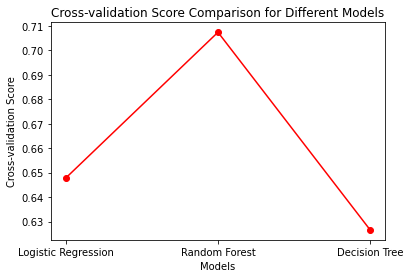

In [219]:
# Example cross-validation scores for each model
results = {
    'Logistic Regression': {'cross_val_scores': [0.65757636, 0.64357713, 0.64092842, 0.6489319 , 0.64805132]},
    'Random Forest': {'cross_val_scores': [0.70981139, 0.70340706, 0.70312695, 0.71816938, 0.70284165]},
    'Decision Tree': {'cross_val_scores': [[0.61438899, 0.62747671, 0.62928366, 0.63272183, 0.62893726]]}
}

# Extract cross-validation scores for each model
logreg_scores = results['Logistic Regression']['cross_val_scores']
rf_scores = results['Random Forest']['cross_val_scores']
dt_scores = results['Decision Tree']['cross_val_scores']

logreg_scores = np.mean(logreg_scores)
rf_scores =np.mean(rf_scores)
dt_scores= np.mean(dt_scores)

# Create a list with the cross-validation scores
cross_val_list = [logreg_scores, rf_scores, dt_scores]

# Plot the results
models = ['Logistic Regression', 'Random Forest', 'Decision Tree']

plt.plot(models, cross_val_list, marker='o' , color='red')
plt.xlabel('Models')
plt.ylabel('Cross-validation Score')
plt.title('Cross-validation Score Comparison for Different Models')

plt.show()


In [220]:
rf_scores

0.707471286